In [62]:
from ultralytics import YOLO
import os
import cv2
from pathlib import Path

In [63]:
model = YOLO("runs/detect/train3/weights/best.pt")

In [64]:
dataset_root = "MRI Scans"
output_root = "cropped_images"
MARGIN = 25

for split in ["Testing", "Training"]:
    image_dir = Path(dataset_root) / split
    output_dir = Path(output_root) / split
    output_dir.mkdir(parents=True, exist_ok=True)

    for tumor_type in ["glioma", "meningioma","pituitary","no_tumor"]:
        input_folder = image_dir / tumor_type
        output_folder = output_dir / tumor_type
        output_folder.mkdir(parents=True, exist_ok=True)

        for img_path in input_folder.rglob("*.jpg"):
            results = model(str(img_path), device=0) 
            boxes = results[0].boxes.xyxy.cpu().numpy()

            img = cv2.imread(str(img_path))
            h, w = img.shape[:2]
            if len(boxes) > 0:
                img = cv2.imread(str(img_path))
                for i, box in enumerate(boxes):
                    x1, y1, x2, y2 = map(int, box[:4])
                    x1 = max(0, x1 - MARGIN)
                    y1 = max(0, y1 - MARGIN)
                    x2 = min(w, x2 + MARGIN)
                    y2 = min(h, y2 + MARGIN)
                    crop = img[y1:y2, x1:x2]
                    crop_name = f"{img_path.stem}_crop_{i}.jpg"
                    cv2.imwrite(str(output_folder / crop_name), crop)
            else:
                if tumor_type == "no_tumor":
                    img = cv2.imread(str(img_path))
                    cv2.imwrite(str(output_folder / img_path.name), img)



image 1/1 g:\My Programming files\Python dev\Machine Learning Project Final Year\MRI Scans\Testing\glioma\image(1).jpg: 640x512 1 tumor, 6.9ms
Speed: 1.3ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 g:\My Programming files\Python dev\Machine Learning Project Final Year\MRI Scans\Testing\glioma\image(100).jpg: 640x576 1 tumor, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 g:\My Programming files\Python dev\Machine Learning Project Final Year\MRI Scans\Testing\glioma\image(11).jpg: 640x608 1 tumor, 8.8ms
Speed: 1.9ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 g:\My Programming files\Python dev\Machine Learning Project Final Year\MRI Scans\Testing\glioma\image(12).jpg: 640x608 1 tumor, 4.7ms
Speed: 1.7ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 g:\My Programming files\P

In [65]:
import shutil

cropped_dir = Path("cropped_images")
class_output_dir = Path("classification_dataset")

for split in ["training", "testing"]:
    for tumor_type in ["glioma", "meningioma", "pituitary", "no_tumor"]:
        input_dir = cropped_dir / split / tumor_type
        output_dir = class_output_dir / split / tumor_type
        output_dir.mkdir(parents=True, exist_ok=True)

        for img_path in input_dir.glob("*.jpg"):
            shutil.copy(str(img_path), str(output_dir / img_path.name))

In [66]:
from PIL import Image
from pathlib import Path

# Define source and destination paths
input_root = Path("classification_dataset/training")
output_root = Path("classification_dataset_augmented/training")

# Define rotation angles
# angles = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
angles = [0, 90, 180, 270]

# Loop through each class folder
for class_folder in input_root.iterdir():
    if class_folder.is_dir():
        class_name = class_folder.name
        output_class_dir = output_root / class_name
        output_class_dir.mkdir(parents=True, exist_ok=True)

        # Process each image in the class folder
        for img_path in class_folder.glob("*.jpg"):
            try:
                image = Image.open(img_path).convert("RGB")
                for angle in angles:
                    # Rotate image
                    rotated = image.rotate(angle, expand=True)
                    
                    # Generate output file name
                    output_name = f"{img_path.stem}_rot{angle}.jpg"
                    rotated.save(output_class_dir / output_name)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")


In [67]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [68]:
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=30),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("classification_dataset_augmented/training", transform=data_transform)
test_dataset = datasets.ImageFolder("classification_dataset/testing", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [69]:
resnet = models.resnet50(pretrained=True)
# googlenet = models.googlenet(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False
# for param in googlenet.parameters():
#     param.requires_grad = False

g:\My Programming files\Python dev\Machine Learning Project Final Year\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
g:\My Programming files\Python dev\Machine Learning Project Final Year\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
# resnet.fc = nn.Linear(resnet.fc.in_features, 4)

# googlenet.fc = nn.Linear(googlenet.fc.in_features, 4)

resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 2048),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 2048),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 4)
)

# googlenet.fc = nn.Sequential(
#     nn.Linear(googlenet.fc.in_features, 2048),
#     nn.LeakyReLU(negative_slope=0.01, inplace=True),
#     nn.Dropout(p=0.4),
#     nn.Linear(2048, 2048),
#     nn.LeakyReLU(negative_slope=0.01, inplace=True),
#     nn.Dropout(p=0.4),
#     nn.Linear(2048, 4)
# )

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

resnet = resnet.to(device)
# googlenet = googlenet.to(device)

Using device: cuda


In [72]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(list(resnet.fc.parameters()) + list(googlenet.fc.parameters()), lr=1e-4, weight_decay=1e-4)

In [73]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Define class labels and counts (in same order as class_names)
targets = train_loader.dataset.targets
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(targets),
    y=targets
)

# Convert to tensor and send to device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Create weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(list(resnet.fc.parameters()), lr=5e-5, weight_decay=1e-3)

In [74]:
# for epoch in range(50):
#     resnet.train()
#     googlenet.train()
#     total_loss = 0
#     correct = 0
#     total = 0

#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         resnet_out = resnet(images)
#         googlenet_out = googlenet(images)

#         # Ensemble: average outputs
#         outputs = (resnet_out + googlenet_out) / 2

#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)

#     train_acc = 100 * correct / total

#     print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f}, Train Acc = {train_acc:.2f}%")

In [75]:
best_val_acc = 0
patience = 5
trigger_times = 0


for epoch in range(50):
    resnet.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        resnet_out = resnet(images)

        outputs = resnet_out

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_loss = total_loss / len(train_loader)

    # Validation phase
    resnet.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in test_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            val_outputs = resnet(val_images)
            loss = criterion(val_outputs, val_labels)

            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(test_loader)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}%, "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        # Optional: save model here
        torch.save(resnet.state_dict(), "best_resnet_model.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1} 🚨")
            break


Epoch 1: Train Loss = 0.3776, Train Acc = 85.80%, Val Loss = 0.2323, Val Acc = 91.33%
Epoch 2: Train Loss = 0.2596, Train Acc = 89.94%, Val Loss = 0.1790, Val Acc = 94.00%
Epoch 3: Train Loss = 0.2305, Train Acc = 91.02%, Val Loss = 0.1544, Val Acc = 93.86%
Epoch 4: Train Loss = 0.2117, Train Acc = 91.51%, Val Loss = 0.1478, Val Acc = 94.46%
Epoch 5: Train Loss = 0.1947, Train Acc = 92.33%, Val Loss = 0.1595, Val Acc = 95.40%
Epoch 6: Train Loss = 0.1798, Train Acc = 92.91%, Val Loss = 0.1266, Val Acc = 95.73%
Epoch 7: Train Loss = 0.1702, Train Acc = 93.41%, Val Loss = 0.1334, Val Acc = 95.13%
Epoch 8: Train Loss = 0.1607, Train Acc = 93.83%, Val Loss = 0.1087, Val Acc = 96.46%
Epoch 9: Train Loss = 0.1447, Train Acc = 94.33%, Val Loss = 0.1174, Val Acc = 96.26%
Epoch 10: Train Loss = 0.1429, Train Acc = 94.46%, Val Loss = 0.0976, Val Acc = 96.66%
Epoch 11: Train Loss = 0.1338, Train Acc = 94.85%, Val Loss = 0.0895, Val Acc = 96.73%
Epoch 12: Train Loss = 0.1285, Train Acc = 95.06%, V

In [76]:
# resnet.eval()
# googlenet.eval()
# correct = 0
# total = 0

# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         resnet_out = resnet(images)
#         googlenet_out = googlenet(images)
#         outputs = (resnet_out + googlenet_out) / 2
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# accuracy = correct / total * 100
# print(f"Test Accuracy: {accuracy:.2f}%")

In [77]:
resnet.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        resnet_out = resnet(images)
        outputs = resnet_out
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.60%


In [78]:
# resnet.eval()
# googlenet.eval()
# correct_train = 0
# total_train = 0

# with torch.no_grad():
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         resnet_out = resnet(images)
#         googlenet_out = googlenet(images)
#         outputs = (resnet_out + googlenet_out) / 2
#         _, predicted = torch.max(outputs, 1)
#         total_train += labels.size(0)
#         correct_train += (predicted == labels).sum().item()

# train_accuracy = correct_train / total_train * 100
# print(f"Training Accuracy: {train_accuracy:.2f}%")

In [79]:
resnet.eval()

num_classes = len(train_loader.dataset.classes)
class_names = train_loader.dataset.classes

class_correct = [0] * num_classes
class_total = [0] * num_classes
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

# Total training accuracy
train_accuracy = 100 * total_correct / total_samples
print(f"\nTotal Training Accuracy: {train_accuracy:.2f}%\n")

# Per-class training accuracy
for i in range(num_classes):
    if class_total[i] > 0:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"Training accuracy for class '{class_names[i]}': {acc:.2f}%")
    else:
        print(f"No samples for class '{class_names[i]}'")



Total Training Accuracy: 99.01%

Training accuracy for class 'glioma': 97.99%
Training accuracy for class 'meningioma': 98.27%
Training accuracy for class 'no_tumor': 100.00%
Training accuracy for class 'pituitary': 99.74%


In [80]:
resnet.eval()
num_classes = len(test_loader.dataset.classes)
class_names = test_loader.dataset.classes

class_correct = [0] * num_classes
class_total = [0] * num_classes
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

total_accuracy = 100 * total_correct / total_samples
print(f"\nTotal Test Accuracy: {total_accuracy:.2f}%\n")

for i in range(num_classes):
    if class_total[i] > 0:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"Accuracy for class '{class_names[i]}': {acc:.2f}%")
    else:
        print(f"No samples for class '{class_names[i]}'")



Total Test Accuracy: 97.60%

Accuracy for class 'glioma': 94.55%
Accuracy for class 'meningioma': 97.89%
Accuracy for class 'no_tumor': 100.00%
Accuracy for class 'pituitary': 96.08%


In [81]:
from collections import Counter
print(Counter(train_loader.dataset.targets))


Counter({3: 9152, 1: 8676, 2: 8012, 0: 7952})


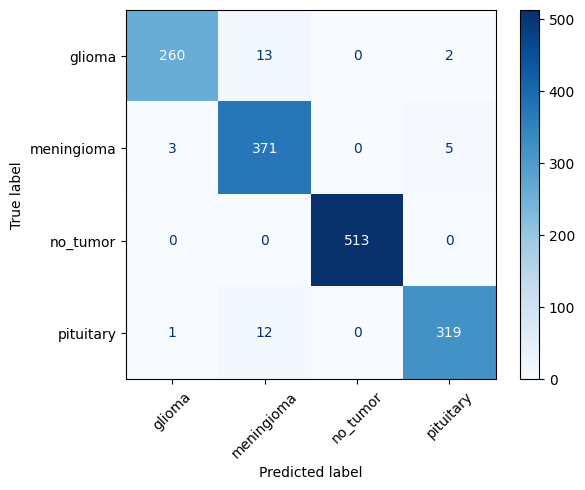

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)


In [85]:
resnet.load_state_dict(torch.load('best_resnet_model.pth', map_location=device))
resnet.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        resnet_out = resnet(images)
        outputs = resnet_out
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.87%
